# RNN 개념이해

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 준비

### (1) 라이브러리 로딩

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Flatten
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [3]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) Data Loading

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


## 2.데이터 이해

온도의 흐름(trend)을 살펴봅시다.

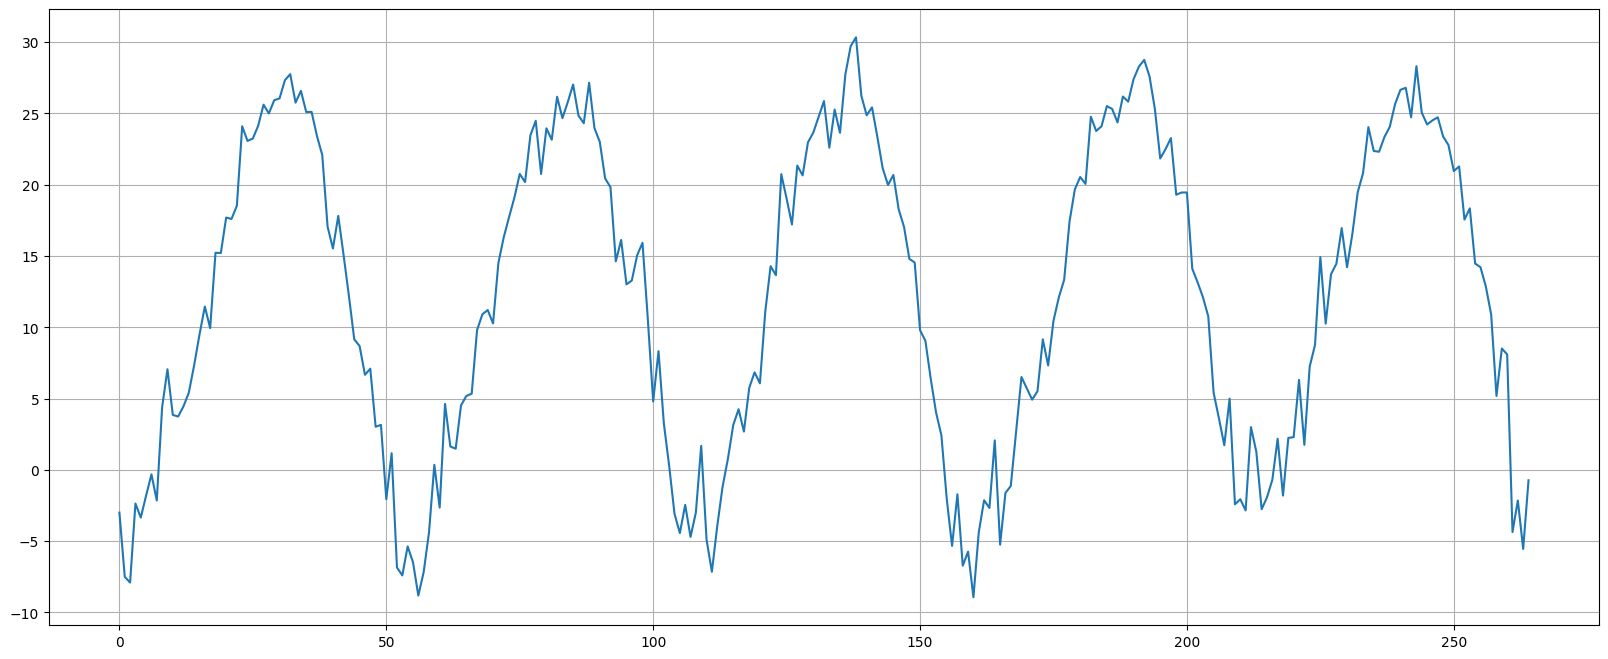

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

##3.데이터 준비

### (1) y 만들기

In [6]:
data['y'] = data['AvgTemp'].shift(-1)
data.dropna(axis = 0, inplace = True)
data.head()
# 시계열 모델링 시 주의사항
# 사전 확인 오류를 범하지 않아야함
# 사전 확인 오류: ex) 내일 주가를 예측할 때 내일의 데이터로 예측하면 안됨, 즉 시점일치 불가

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


### (2) x, y 분리

In [7]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

### (3) 스케일링

In [8]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [9]:
x.shape, y.shape

((264, 1), (264,))

### (4) 3차원 구조 만들기

In [10]:
x2, y2 = temporalize(x, y, 4)
x2.shape, y2.shape

((261, 4, 1), (261,))

In [11]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

In [12]:
y[:7], y2[:2]

(0   -7.500000
 1   -7.900000
 2   -2.357143
 3   -3.342857
 4   -1.800000
 5   -0.314286
 6   -2.142857
 Name: y, dtype: float64,
 array([-3.34285714, -1.8       ]))

### (5) 데이터 분할

* shuffle = False : 섞지 마라.(랜덤 분할 하지 마라)
* test_size= 53 :
    * 소수 : 비율
    * 자연수 : 개수

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

In [14]:
x_train.shape, y_train.shape

((208, 4, 1), (208,))

In [15]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## 4.RNN : 무작정 모델링

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [16]:
x_train.shape

(208, 4, 1)

In [17]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

In [18]:
print(timesteps, nfeatures)

4 1


### (2) 모델 구조 설계
* 다음 구조를 그대로 설계해 봅시다.
    * SimpleRNN(8, input_shape = (timesteps, nfeatures))
    * Dense(1)

In [19]:
clear_session()

model = Sequential([SimpleRNN(8, input_shape=(timesteps, nfeatures)), # default activation function: tanh
                    Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [20]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
hist = model.fit(x_train, y_train, epochs=100, validation_split=.2, verbose=0).history

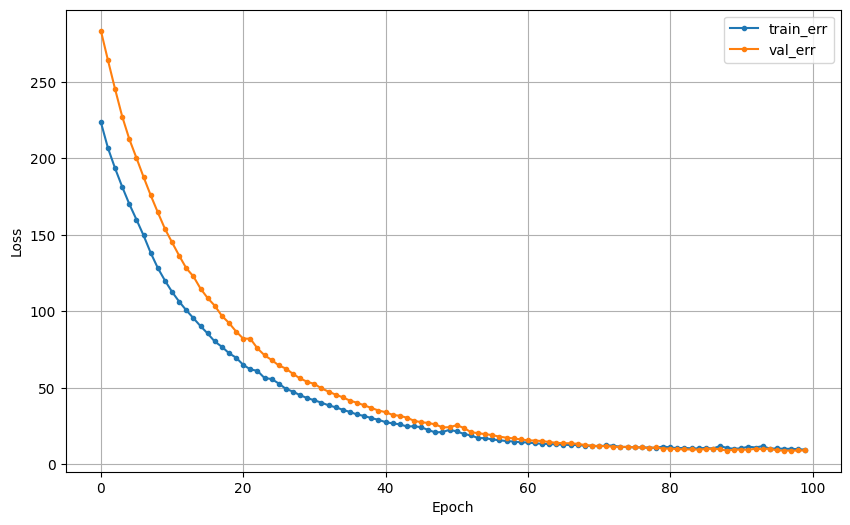

In [21]:
# 학습 곡선을 그려봅시다.
dl_history_plot(hist)

### (4) 예측 및 평가

In [22]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 1s 14ms/step


In [23]:
# 평가
print(mean_squared_error(y_val, pred, squared=False))
print(mean_absolute_error(y_val, pred))

3.7902631609105657
2.951133048226714


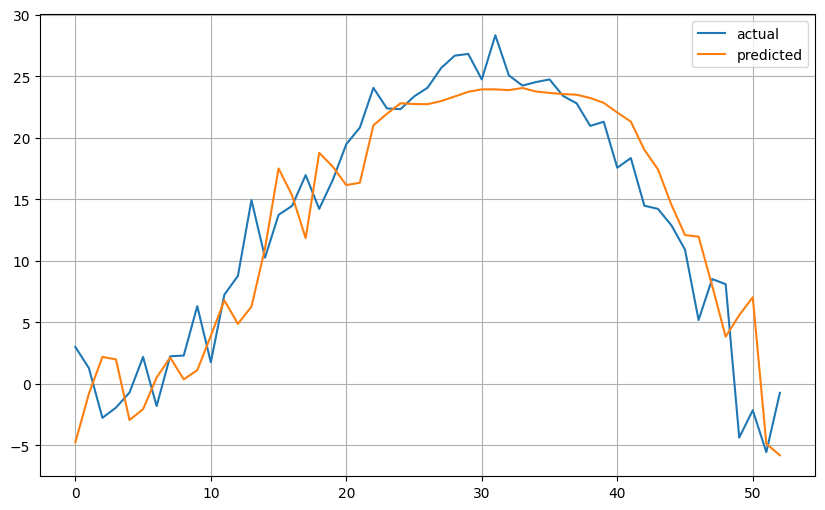

In [24]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 5.RNN 모델링②

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [25]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 이제 RNN 레이어를 추가해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences = True)
    * SimpleRNN(8)
    * Dense(1)

In [26]:
clear_session()
model2 = Sequential([
    SimpleRNN(8, input_shape=(timesteps, nfeatures), return_sequences=True), # 4x8 이 그대로 넘어감
    SimpleRNN(8, return_sequences=False), # 4x8 형태로 만들어지고, 가장 마지막의 데이터가 Dense(1)과 연결됨
    Dense(1)
])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 8)              80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 200
    * learning_rate = 0.01

In [28]:
model2.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
hist = model2.fit(x_train, y_train, epochs=200, validation_split=.2, verbose=0).history

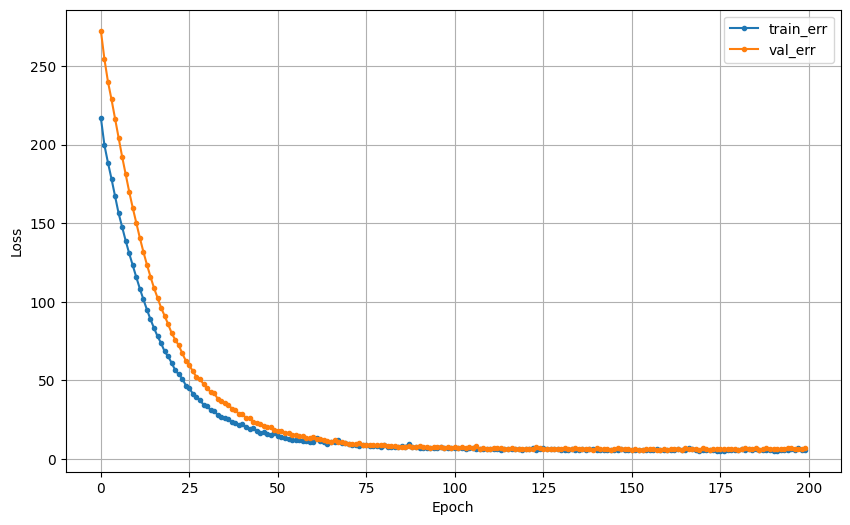

In [29]:
# 학습 곡선을 그려봅시다.
dl_history_plot(hist)

### (4) 예측 및 평가

In [30]:
# 예측
pred = model2.predict(x_val)

2/2 [==============================] - 1s 14ms/step


In [31]:
# 평가
print(mean_squared_error(y_val, pred, squared=False))
print(mean_absolute_error(y_val, pred))

3.087982421851425
2.235683627916543


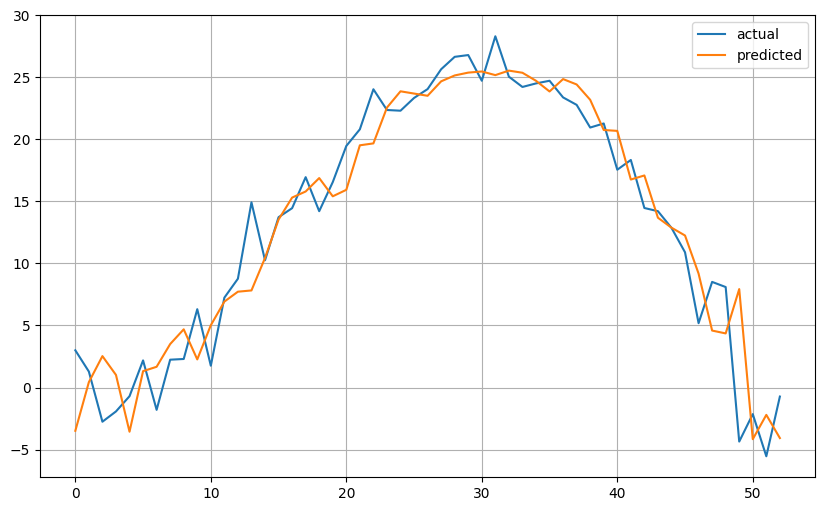

In [32]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 6.LSTM 모델링

### (1) 데이터 준비

* timestep

In [33]:
timesteps = 14
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((251, 14, 1), (251,))

* 데이터 분할

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [35]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계
* 5번 모델의 SimpleRNN을 LSTM 로 이름만 바꿔봅시다.

In [36]:
clear_session()
model3 = Sequential([
     LSTM(8, input_shape=(timesteps, nfeatures), return_sequences=True),
     LSTM(8, return_sequences=False),
    Dense(1)
])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 873 (3.41 KB)
Trainable params: 873 (3.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (4) 컴파일 및 학습

In [37]:
model3.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
hist = model3.fit(x_train, y_train, epochs=200, validation_split=.2, verbose=0).history

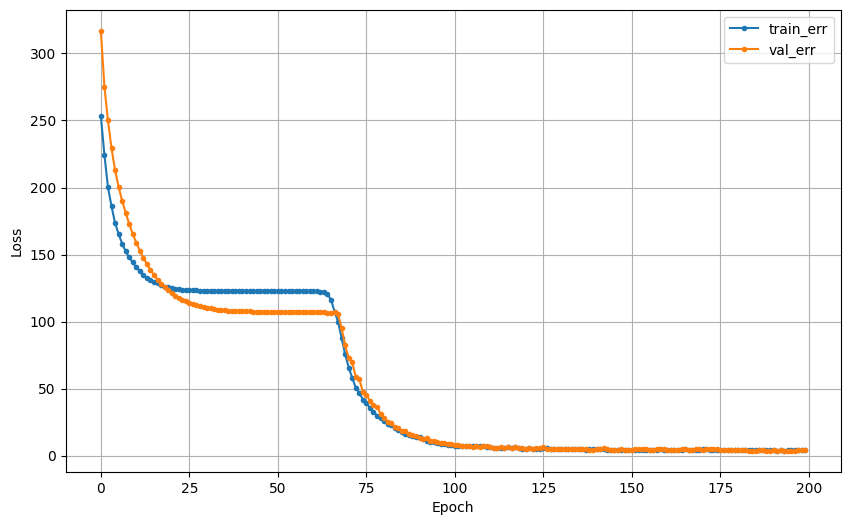

In [38]:
dl_history_plot(hist)

### (5) 예측 및 평가

In [39]:
pred = model3.predict(x_val)

2/2 [==============================] - 1s 8ms/step


In [40]:
print(mean_squared_error(y_val, pred, squared=False))
print(mean_absolute_error(y_val, pred))

2.7669363950108004
2.1770732613501047


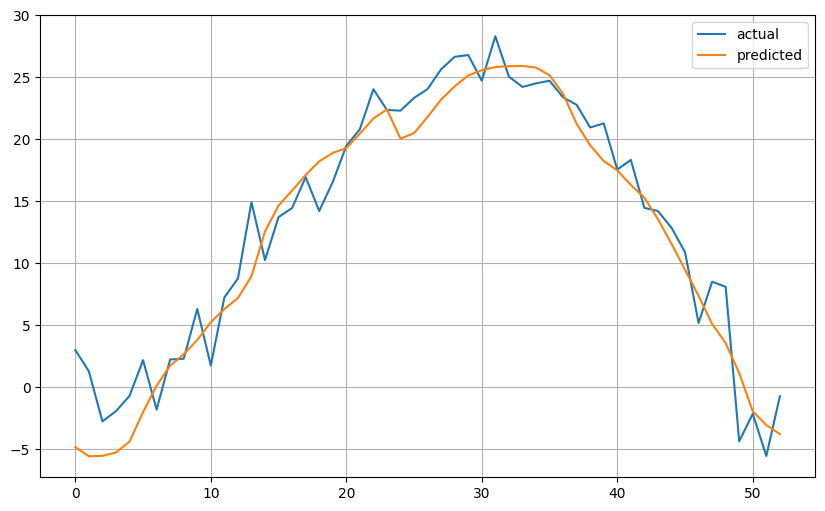

In [41]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 7.자유롭게 모델링~!
* 다음 항목을 조정하며 모델링을 수행해 봅시다.
    * timestep
    * 레이어와 노드수
    * learning_rate, epochs


### (1) 데이터 준비

* timestep

In [42]:
timesteps = 20
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((245, 20, 1), (245,))

* 데이터 분할

In [43]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [47]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


In [54]:
clear_session()

model4 = Sequential([
    LSTM(16, input_shape=(timesteps, nfeatures), return_sequences=True),
    LSTM(8, return_sequences=True),
    Flatten(),
    Dense(4, activation='relu'),
    Dense(1)
])

model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 20, 8)             800       
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 4)                 644       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 2601 (10.16 KB)
Trainable params: 2601 (10.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (4) 컴파일 및 학습

In [55]:
model4.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
hist = model4.fit(x_train, y_train, epochs=150, validation_split=.2, verbose=0).history

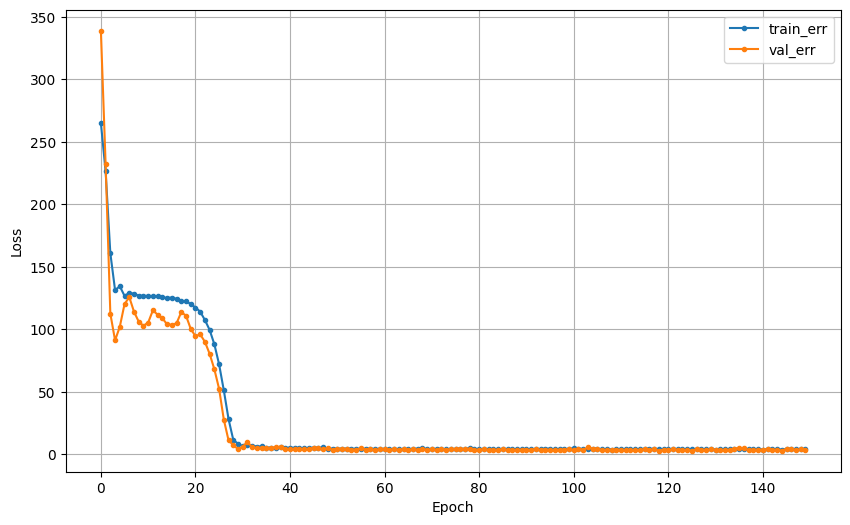

In [56]:
dl_history_plot(hist)

### (5) 예측 및 평가

In [57]:
pred = model4.predict(x_val)

2/2 [==============================] - 1s 13ms/step


In [58]:
print(mean_squared_error(y_val, pred, squared=False))
print(mean_absolute_error(y_val, pred))

3.003111476166902
2.291662527870148


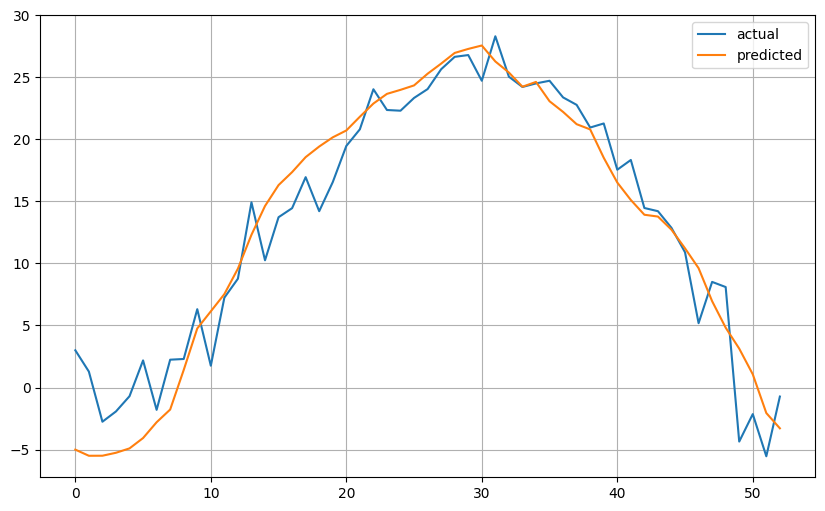

In [59]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

In [66]:
clear_session()

model5 = Sequential([
    SimpleRNN(16, input_shape=(timesteps, nfeatures), return_sequences=True),
    SimpleRNN(8, return_sequences=True),
    SimpleRNN(2),
    Dense(1)
])

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 16)            288       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 8)             200       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 2)                 22        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
model5.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
hist = model5.fit(x_train, y_train, epochs=350, validation_split=.2, verbose=0).history

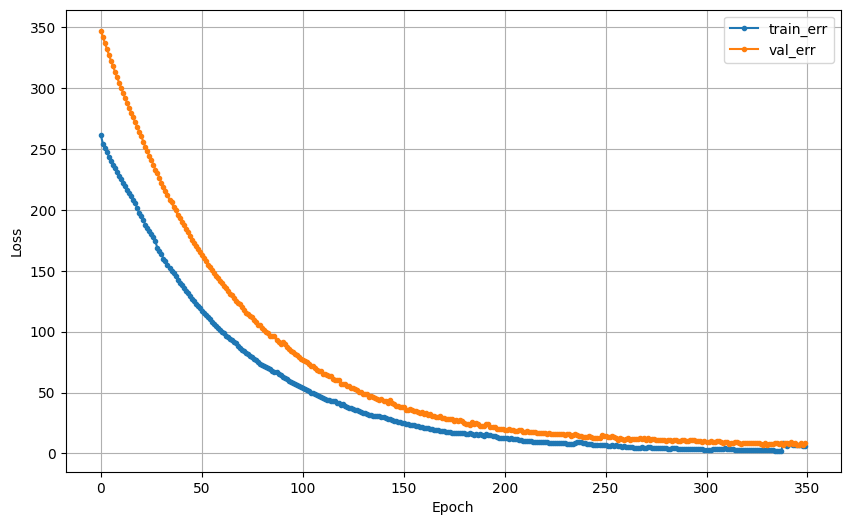

In [68]:
dl_history_plot(hist)

In [69]:
pred = model5.predict(x_val)

2/2 [==============================] - 0s 9ms/step


In [70]:
print(mean_squared_error(y_val, pred, squared=False))
print(mean_absolute_error(y_val, pred))

3.3849315991585276
2.6400411156819397


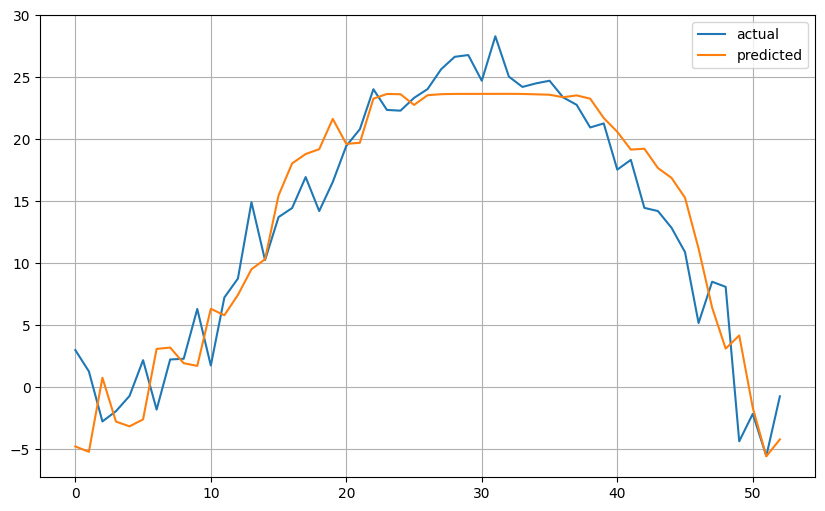

In [71]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()